In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
long = pd.read_csv('Data/clean_dfs/long_absence.csv')
short = pd.read_csv('Data/clean_dfs/short_absence.csv')

In [9]:
long.columns

Index(['survey_year', 'survey_month', 'year_month', 'province',
       'nine_largest_cmas', 'five_year_age_group', 'age_group_15_29', 'sex',
       'marital_status', 'highest_educational_attainment',
       'single_or_multiple_jobholder', 'class_of_worker_main_job',
       'immigrant_status', 'industry_of_main_job',
       'occupation_at_main_job_col1', 'occupation_at_main_job_col2',
       'reason_of_absence_full_week', 'number_of_weeks_absent_from_work',
       'paid_for_time_off_full_week_absence',
       'usual_hours_worked_per_week_at_main_job',
       'actual_hours_worked_per_week_at_main_job',
       'full_or_part_time_main_job', 'usual_hours_worked_per_week_all_jobs',
       'actual_hours_worked_per_week_all_jobs',
       'paid_overtime_hours_in_reference_week',
       'unpaid_overtime_hours_in_reference_week',
       'number_of_overtime_or_extra_hours_worked', 'reason_for_part_time_work',
       'job_tenure_months_current_employer', 'usual_hourly_wages',
       'union_status',

In [6]:
long['number_of_weeks_absent_from_work'].min(), long['number_of_weeks_absent_from_work'].max(), long['number_of_weeks_absent_from_work'].mean()

(1.0, 99.0, 13.633079434167573)

In [7]:
# https://www.canada.ca/en/services/jobs/workplace/federal-labour-standards/vacations-holidays.html

# Annual vacation entitlement
# As an employee working for a federally regulated employer, you are entitled to at least:

# 2 weeks of vacation annually after you have completed 1 year of employment with the same employer
# 3 weeks of vacation annually after you have completed 5 consecutive years of employment with the same employer, and
# 4 weeks of vacation annually after you have completed 10 consecutive years of employment with the same employer

In [16]:
def add_allowed_vacation_weeks(months):
    if months < 12:
        return 0
    elif months < (12*5):
        return 2
    elif months < (12*10):
        return 3
    else:
        return 4

In [19]:
long['allowed_vacation_weeks']=long['job_tenure_months_current_employer'].map(lambda x: add_allowed_vacation_weeks(x))

In [33]:
long['absentismo'] = long.apply(lambda row: 0 if row['allowed_vacation_weeks']>row['number_of_weeks_absent_from_work'] else 1, axis=1)

In [34]:
long['absentismo'].value_counts(10)

absentismo
1    0.634813
0    0.365187
Name: proportion, dtype: float64

In [35]:
long[long['absentismo']==1][['allowed_vacation_weeks','number_of_weeks_absent_from_work']]

,allowed_vacation_weeks,number_of_weeks_absent_from_work
0,2,5.0
3,2,50.0
4,4,4.0
5,0,2.0
6,2,28.0
...,...,...
275693,4,16.0
275695,0,1.0
275696,3,56.0
275697,4,40.0


In [40]:
more_than_month_absent = long[long['number_of_weeks_absent_from_work']>4]

In [41]:
absent = long[long['absentismo']==1]

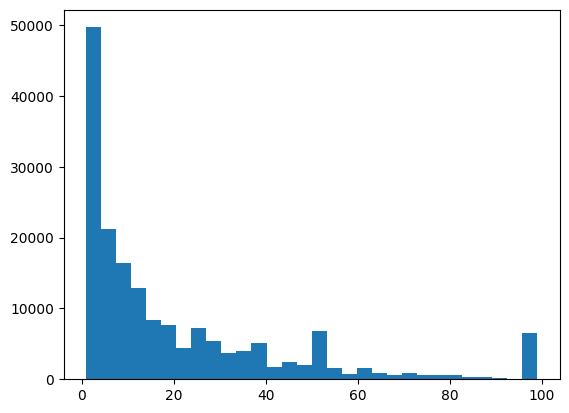

In [47]:
plt.hist(absent['number_of_weeks_absent_from_work'], bins=30);

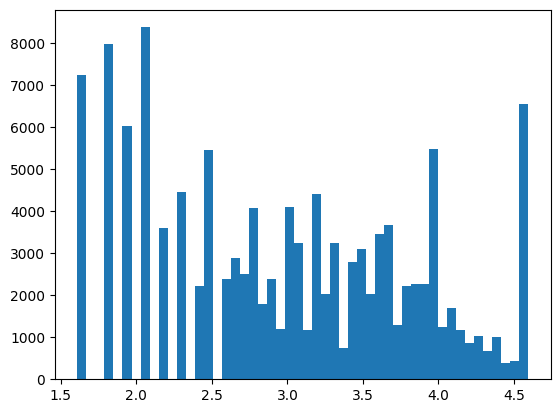

In [46]:
plt.hist(np.log(more_than_month_absent['number_of_weeks_absent_from_work']), bins=50);

In [50]:
more_than_month_absent.columns

Index(['survey_year', 'survey_month', 'year_month', 'province',
       'nine_largest_cmas', 'five_year_age_group', 'age_group_15_29', 'sex',
       'marital_status', 'highest_educational_attainment',
       'single_or_multiple_jobholder', 'class_of_worker_main_job',
       'immigrant_status', 'industry_of_main_job',
       'occupation_at_main_job_col1', 'occupation_at_main_job_col2',
       'reason_of_absence_full_week', 'number_of_weeks_absent_from_work',
       'paid_for_time_off_full_week_absence',
       'usual_hours_worked_per_week_at_main_job',
       'actual_hours_worked_per_week_at_main_job',
       'full_or_part_time_main_job', 'usual_hours_worked_per_week_all_jobs',
       'actual_hours_worked_per_week_all_jobs',
       'paid_overtime_hours_in_reference_week',
       'unpaid_overtime_hours_in_reference_week',
       'number_of_overtime_or_extra_hours_worked', 'reason_for_part_time_work',
       'job_tenure_months_current_employer', 'usual_hourly_wages',
       'union_status',

In [55]:
X = more_than_month_absent[['survey_year', 'survey_month', 'province',
       'nine_largest_cmas', 'five_year_age_group', 'age_group_15_29', 'sex',
       'marital_status', 'highest_educational_attainment',
       'single_or_multiple_jobholder', 'class_of_worker_main_job',
       'immigrant_status', 'industry_of_main_job',
       'occupation_at_main_job_col1', 'occupation_at_main_job_col2',
       'reason_of_absence_full_week', 
       'paid_for_time_off_full_week_absence',
       'usual_hours_worked_per_week_at_main_job',
       'full_or_part_time_main_job', 'reason_for_part_time_work',
       'job_tenure_months_current_employer', 'usual_hourly_wages',
       'union_status', 'job_permanency', 'establishment_size', 'firm_size',
       'current_student_status', 'type_of_economic_family',
       'age_of_youngest_child', 'standard_final_weight', 'allowed_vacation_weeks']]
y = more_than_month_absent['number_of_weeks_absent_from_work']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [59]:
categorical_columns = list(x_train.columns[list(x_train.dtypes == 'object')])

from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=500,
                        learning_rate=0.5,
                        depth = 10,
                        random_seed= 22,
                      #  verbose=False,
                        cat_features=categorical_columns)
  
model.fit(x_train, y_train)

from sklearn import metrics

print('R2 score train', model.score(x_train,y_train))
print(' ')
print('R2 Score test:', metrics.r2_score(y_test, model.predict(x_test)))

0:	learn: 22.8455994	total: 459ms	remaining: 3m 49s
1:	learn: 22.1825375	total: 982ms	remaining: 4m 4s
2:	learn: 21.8287311	total: 1.57s	remaining: 4m 21s
3:	learn: 21.6189578	total: 2.03s	remaining: 4m 11s
4:	learn: 21.4833749	total: 2.48s	remaining: 4m 5s
5:	learn: 21.3103282	total: 2.95s	remaining: 4m 2s
6:	learn: 21.2284389	total: 3.42s	remaining: 4m
7:	learn: 21.1579456	total: 3.85s	remaining: 3m 56s
8:	learn: 20.9088302	total: 4.31s	remaining: 3m 55s
9:	learn: 20.7978757	total: 4.82s	remaining: 3m 56s
10:	learn: 20.7379441	total: 5.35s	remaining: 3m 57s
11:	learn: 20.6444068	total: 5.91s	remaining: 4m
12:	learn: 20.5327975	total: 6.46s	remaining: 4m 1s
13:	learn: 20.4220550	total: 6.92s	remaining: 4m
14:	learn: 20.2919535	total: 7.45s	remaining: 4m
15:	learn: 20.1850314	total: 7.99s	remaining: 4m 1s
16:	learn: 20.1277104	total: 8.5s	remaining: 4m 1s
17:	learn: 20.1012729	total: 8.98s	remaining: 4m
18:	learn: 19.9949095	total: 9.52s	remaining: 4m 1s
19:	learn: 19.9501476	total: 10

155:	learn: 15.4258112	total: 1m 27s	remaining: 3m 13s
156:	learn: 15.3689718	total: 1m 28s	remaining: 3m 13s
157:	learn: 15.3412678	total: 1m 29s	remaining: 3m 12s
158:	learn: 15.3395762	total: 1m 29s	remaining: 3m 12s
159:	learn: 15.3265325	total: 1m 30s	remaining: 3m 11s
160:	learn: 15.3144218	total: 1m 30s	remaining: 3m 11s
161:	learn: 15.2895774	total: 1m 31s	remaining: 3m 10s
162:	learn: 15.2832329	total: 1m 31s	remaining: 3m 9s
163:	learn: 15.2823126	total: 1m 32s	remaining: 3m 9s
164:	learn: 15.2506967	total: 1m 32s	remaining: 3m 8s
165:	learn: 15.2350816	total: 1m 33s	remaining: 3m 8s
166:	learn: 15.2179048	total: 1m 34s	remaining: 3m 7s
167:	learn: 15.2098255	total: 1m 34s	remaining: 3m 7s
168:	learn: 15.2079422	total: 1m 35s	remaining: 3m 6s
169:	learn: 15.2002401	total: 1m 36s	remaining: 3m 6s
170:	learn: 15.1652421	total: 1m 36s	remaining: 3m 6s
171:	learn: 15.1442094	total: 1m 37s	remaining: 3m 5s
172:	learn: 15.1245655	total: 1m 38s	remaining: 3m 5s
173:	learn: 15.124383

306:	learn: 13.0578305	total: 2m 56s	remaining: 1m 50s
307:	learn: 13.0475195	total: 2m 56s	remaining: 1m 50s
308:	learn: 13.0336811	total: 2m 57s	remaining: 1m 49s
309:	learn: 13.0307598	total: 2m 57s	remaining: 1m 49s
310:	learn: 13.0284619	total: 2m 58s	remaining: 1m 48s
311:	learn: 13.0051443	total: 2m 59s	remaining: 1m 47s
312:	learn: 12.9945481	total: 2m 59s	remaining: 1m 47s
313:	learn: 12.9580164	total: 3m	remaining: 1m 46s
314:	learn: 12.9559992	total: 3m	remaining: 1m 46s
315:	learn: 12.9555815	total: 3m 1s	remaining: 1m 45s
316:	learn: 12.9312224	total: 3m 2s	remaining: 1m 45s
317:	learn: 12.9057279	total: 3m 2s	remaining: 1m 44s
318:	learn: 12.8931615	total: 3m 3s	remaining: 1m 43s
319:	learn: 12.8701083	total: 3m 3s	remaining: 1m 43s
320:	learn: 12.8574722	total: 3m 4s	remaining: 1m 42s
321:	learn: 12.8377428	total: 3m 4s	remaining: 1m 42s
322:	learn: 12.8047151	total: 3m 5s	remaining: 1m 41s
323:	learn: 12.8004920	total: 3m 5s	remaining: 1m 41s
324:	learn: 12.7885393	tota

458:	learn: 11.0878750	total: 4m 29s	remaining: 24s
459:	learn: 11.0848880	total: 4m 29s	remaining: 23.4s
460:	learn: 11.0825415	total: 4m 30s	remaining: 22.9s
461:	learn: 11.0502080	total: 4m 30s	remaining: 22.3s
462:	learn: 11.0426741	total: 4m 31s	remaining: 21.7s
463:	learn: 11.0323181	total: 4m 32s	remaining: 21.1s
464:	learn: 11.0240223	total: 4m 32s	remaining: 20.5s
465:	learn: 11.0169107	total: 4m 33s	remaining: 19.9s
466:	learn: 11.0051157	total: 4m 33s	remaining: 19.4s
467:	learn: 11.0033150	total: 4m 34s	remaining: 18.8s
468:	learn: 10.9861225	total: 4m 35s	remaining: 18.2s
469:	learn: 10.9855586	total: 4m 35s	remaining: 17.6s
470:	learn: 10.9850718	total: 4m 36s	remaining: 17s
471:	learn: 10.9677528	total: 4m 36s	remaining: 16.4s
472:	learn: 10.9590842	total: 4m 37s	remaining: 15.8s
473:	learn: 10.9426084	total: 4m 38s	remaining: 15.3s
474:	learn: 10.9414585	total: 4m 38s	remaining: 14.7s
475:	learn: 10.9380165	total: 4m 39s	remaining: 14.1s
476:	learn: 10.9158602	total: 4m

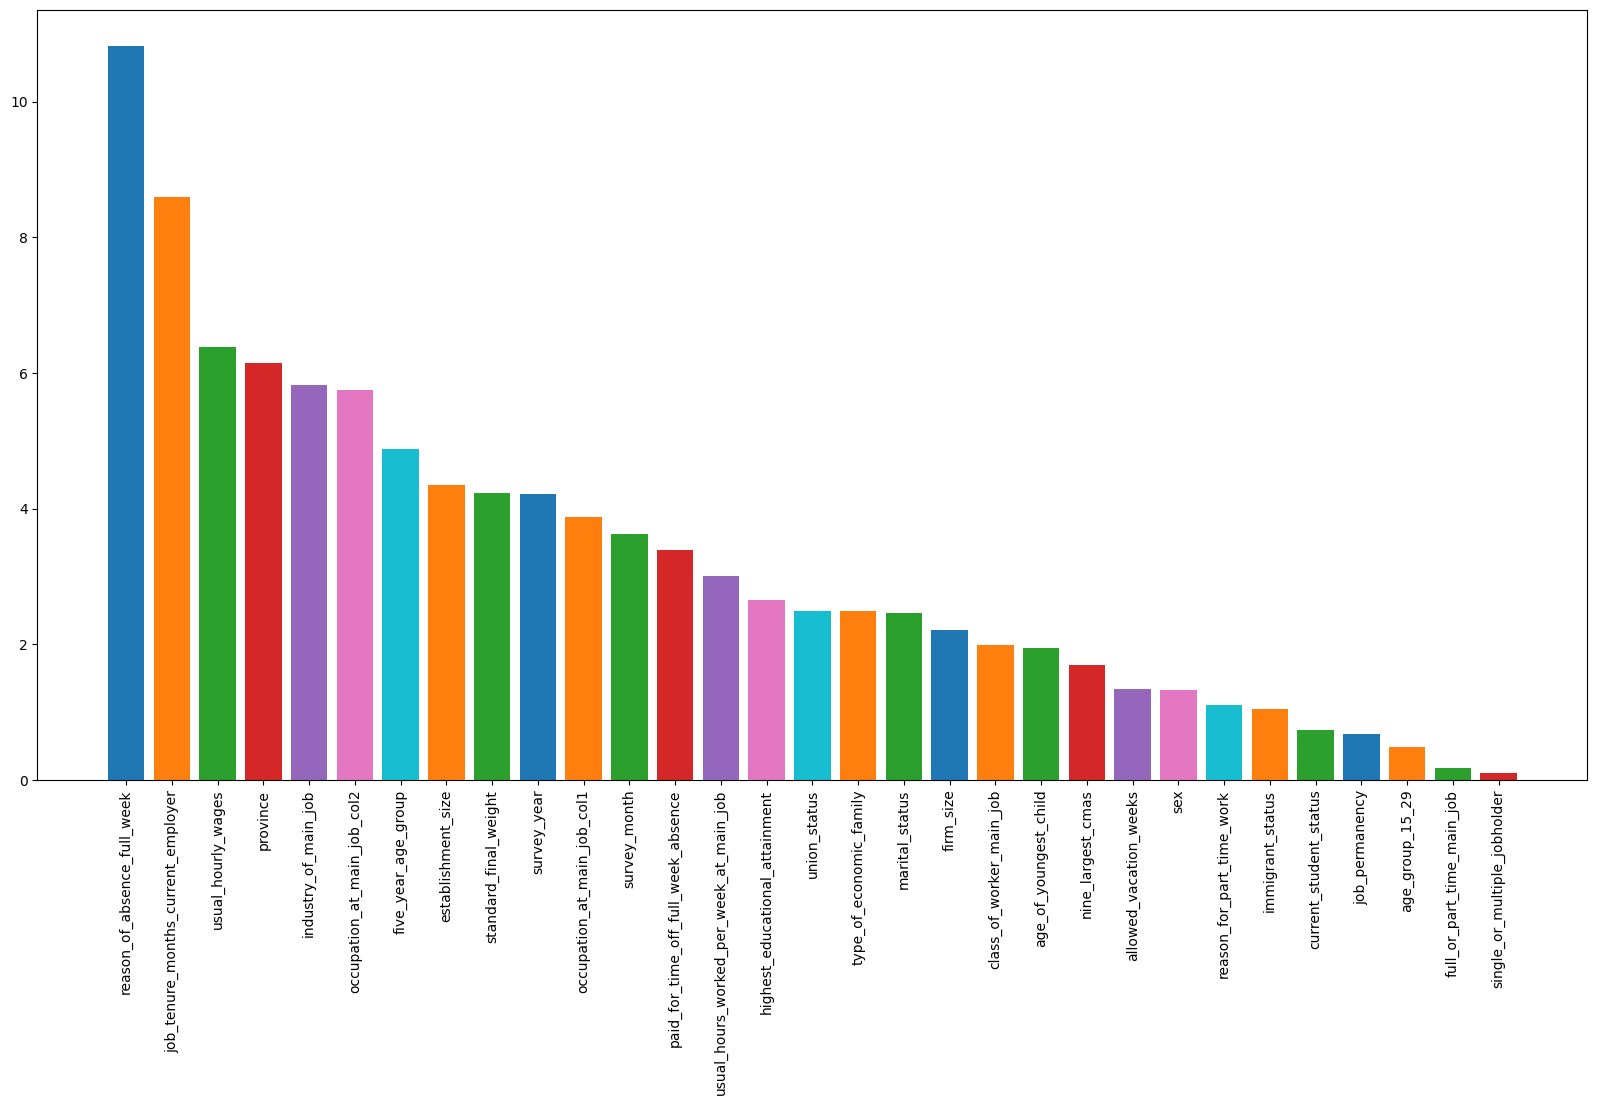

In [60]:
feature_importances = pd.DataFrame(list(zip(model.get_feature_importance(), x_train.columns)))
feature_importances.columns = ['importance', 'feature']
feature_importances = feature_importances.sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize =(20, 10))
color =['tab:blue', 'tab:orange',
'tab:green', 'tab:red', 'tab:purple',
'tab:pink', 'tab:cyan',
'tab:orange', 'tab:green']
ax.bar(feature_importances.feature,
feature_importances['importance'],
color = color)
ax.spines['bottom'].set_position('zero')
#ax.set_ylim([-0.5,0.7])
plt.xticks(rotation=90)
plt.style.use('ggplot');

In [62]:
# quitar: 'single_or_multiple_jobholder','full_or_part_time_main_job', 'age_group_15_29', 'job_permanency','current_student_status', 
X = more_than_month_absent[['survey_year', 'survey_month', 'province',  
       'nine_largest_cmas', 'five_year_age_group', 'sex',
       'marital_status', 'highest_educational_attainment',
       'class_of_worker_main_job',
       'immigrant_status', 'industry_of_main_job',
       'occupation_at_main_job_col1', 'occupation_at_main_job_col2',
       'reason_of_absence_full_week', 
       'paid_for_time_off_full_week_absence',
       'usual_hours_worked_per_week_at_main_job',
       'reason_for_part_time_work',
       'job_tenure_months_current_employer', 'usual_hourly_wages',
       'union_status','establishment_size', 'firm_size',
       'type_of_economic_family',
       'age_of_youngest_child', 'standard_final_weight', 'allowed_vacation_weeks']]

y = more_than_month_absent['number_of_weeks_absent_from_work']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [67]:
categorical_columns = list(x_train.columns[list(x_train.dtypes == 'object')])

from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=5000,
                        learning_rate=0.5,
                        depth = 8,
                        random_seed= 22,
                      #  verbose=False,
                        cat_features=categorical_columns)
  
model.fit(x_train, y_train)

from sklearn import metrics

print('R2 score train', model.score(x_train,y_train))
print(' ')
print('R2 Score test:', metrics.r2_score(y_test, model.predict(x_test)))

0:	learn: 23.0229874	total: 298ms	remaining: 24m 52s
1:	learn: 22.4108863	total: 581ms	remaining: 24m 12s
2:	learn: 22.0704368	total: 910ms	remaining: 25m 15s
3:	learn: 21.9208800	total: 1.17s	remaining: 24m 26s
4:	learn: 21.7753501	total: 1.44s	remaining: 24m 3s
5:	learn: 21.6736972	total: 1.73s	remaining: 23m 58s
6:	learn: 21.5601857	total: 2.05s	remaining: 24m 24s
7:	learn: 21.5267099	total: 2.34s	remaining: 24m 18s
8:	learn: 21.4615432	total: 2.66s	remaining: 24m 36s
9:	learn: 21.4167953	total: 2.92s	remaining: 24m 19s
10:	learn: 21.3698977	total: 3.22s	remaining: 24m 21s
11:	learn: 21.3215235	total: 3.55s	remaining: 24m 34s
12:	learn: 21.2807985	total: 3.91s	remaining: 24m 59s
13:	learn: 21.2515645	total: 4.21s	remaining: 24m 58s
14:	learn: 21.2121869	total: 4.57s	remaining: 25m 19s
15:	learn: 21.1730303	total: 4.88s	remaining: 25m 20s
16:	learn: 21.1627798	total: 5.17s	remaining: 25m 16s
17:	learn: 21.1243329	total: 5.52s	remaining: 25m 27s
18:	learn: 21.0950691	total: 5.83s	rema

153:	learn: 18.3770013	total: 1m	remaining: 31m 54s
154:	learn: 18.3715801	total: 1m 1s	remaining: 32m
155:	learn: 18.3660413	total: 1m 2s	remaining: 32m 5s
156:	learn: 18.3386647	total: 1m 2s	remaining: 32m 13s
157:	learn: 18.3146092	total: 1m 3s	remaining: 32m 20s
158:	learn: 18.3019406	total: 1m 3s	remaining: 32m 26s
159:	learn: 18.2962944	total: 1m 4s	remaining: 32m 29s
160:	learn: 18.2910214	total: 1m 4s	remaining: 32m 32s
161:	learn: 18.2794703	total: 1m 5s	remaining: 32m 35s
162:	learn: 18.2740867	total: 1m 6s	remaining: 32m 41s
163:	learn: 18.2739017	total: 1m 6s	remaining: 32m 45s
164:	learn: 18.2700196	total: 1m 7s	remaining: 32m 47s
165:	learn: 18.2526406	total: 1m 7s	remaining: 32m 52s
166:	learn: 18.2468759	total: 1m 8s	remaining: 32m 57s
167:	learn: 18.2404857	total: 1m 8s	remaining: 33m 1s
168:	learn: 18.2270460	total: 1m 9s	remaining: 33m 5s
169:	learn: 18.2059489	total: 1m 10s	remaining: 33m 9s
170:	learn: 18.1986941	total: 1m 10s	remaining: 33m 11s
171:	learn: 18.1864

301:	learn: 16.8549407	total: 2m 22s	remaining: 36m 55s
302:	learn: 16.8491225	total: 2m 22s	remaining: 36m 54s
303:	learn: 16.8439220	total: 2m 23s	remaining: 36m 55s
304:	learn: 16.8362488	total: 2m 24s	remaining: 36m 56s
305:	learn: 16.8326090	total: 2m 24s	remaining: 36m 56s
306:	learn: 16.8230550	total: 2m 25s	remaining: 36m 57s
307:	learn: 16.8199098	total: 2m 25s	remaining: 36m 57s
308:	learn: 16.8028630	total: 2m 26s	remaining: 36m 58s
309:	learn: 16.7975765	total: 2m 26s	remaining: 36m 58s
310:	learn: 16.7961146	total: 2m 27s	remaining: 36m 59s
311:	learn: 16.7809665	total: 2m 27s	remaining: 36m 59s
312:	learn: 16.7806365	total: 2m 28s	remaining: 36m 58s
313:	learn: 16.7733139	total: 2m 28s	remaining: 36m 58s
314:	learn: 16.7554318	total: 2m 29s	remaining: 36m 58s
315:	learn: 16.7432404	total: 2m 29s	remaining: 36m 58s
316:	learn: 16.7300039	total: 2m 30s	remaining: 36m 58s
317:	learn: 16.7220537	total: 2m 30s	remaining: 36m 59s
318:	learn: 16.7056621	total: 2m 31s	remaining: 

449:	learn: 15.6523646	total: 3m 34s	remaining: 36m 5s
450:	learn: 15.6409557	total: 3m 34s	remaining: 36m 3s
451:	learn: 15.6328259	total: 3m 34s	remaining: 36m 2s
452:	learn: 15.6262785	total: 3m 35s	remaining: 36m
453:	learn: 15.6148761	total: 3m 35s	remaining: 35m 58s
454:	learn: 15.6085579	total: 3m 35s	remaining: 35m 56s
455:	learn: 15.6079662	total: 3m 36s	remaining: 35m 54s
456:	learn: 15.5914732	total: 3m 36s	remaining: 35m 52s
457:	learn: 15.5868777	total: 3m 36s	remaining: 35m 49s
458:	learn: 15.5789644	total: 3m 37s	remaining: 35m 47s
459:	learn: 15.5704180	total: 3m 37s	remaining: 35m 45s
460:	learn: 15.5630634	total: 3m 37s	remaining: 35m 43s
461:	learn: 15.5443806	total: 3m 38s	remaining: 35m 41s
462:	learn: 15.5419826	total: 3m 38s	remaining: 35m 39s
463:	learn: 15.5280866	total: 3m 38s	remaining: 35m 37s
464:	learn: 15.5130059	total: 3m 38s	remaining: 35m 35s
465:	learn: 15.5095323	total: 3m 39s	remaining: 35m 33s
466:	learn: 15.4904196	total: 3m 39s	remaining: 35m 31s

597:	learn: 14.6753304	total: 4m 23s	remaining: 32m 16s
598:	learn: 14.6735278	total: 4m 23s	remaining: 32m 14s
599:	learn: 14.6704594	total: 4m 23s	remaining: 32m 13s
600:	learn: 14.6568163	total: 4m 23s	remaining: 32m 12s
601:	learn: 14.6481507	total: 4m 24s	remaining: 32m 11s
602:	learn: 14.6441927	total: 4m 24s	remaining: 32m 9s
603:	learn: 14.6317269	total: 4m 25s	remaining: 32m 8s
604:	learn: 14.6226272	total: 4m 25s	remaining: 32m 7s
605:	learn: 14.6190023	total: 4m 25s	remaining: 32m 6s
606:	learn: 14.6139305	total: 4m 25s	remaining: 32m 4s
607:	learn: 14.6103807	total: 4m 26s	remaining: 32m 3s
608:	learn: 14.6028132	total: 4m 26s	remaining: 32m 1s
609:	learn: 14.5953299	total: 4m 26s	remaining: 32m
610:	learn: 14.5928636	total: 4m 27s	remaining: 31m 59s
611:	learn: 14.5857781	total: 4m 27s	remaining: 31m 58s
612:	learn: 14.5826532	total: 4m 27s	remaining: 31m 57s
613:	learn: 14.5809635	total: 4m 28s	remaining: 31m 57s
614:	learn: 14.5783141	total: 4m 28s	remaining: 31m 56s
615

745:	learn: 13.8933634	total: 5m 13s	remaining: 29m 46s
746:	learn: 13.8879794	total: 5m 13s	remaining: 29m 45s
747:	learn: 13.8779557	total: 5m 13s	remaining: 29m 44s
748:	learn: 13.8716436	total: 5m 14s	remaining: 29m 43s
749:	learn: 13.8583445	total: 5m 14s	remaining: 29m 42s
750:	learn: 13.8548659	total: 5m 14s	remaining: 29m 41s
751:	learn: 13.8523380	total: 5m 15s	remaining: 29m 40s
752:	learn: 13.8480619	total: 5m 15s	remaining: 29m 39s
753:	learn: 13.8411471	total: 5m 15s	remaining: 29m 38s
754:	learn: 13.8357420	total: 5m 16s	remaining: 29m 37s
755:	learn: 13.8343469	total: 5m 16s	remaining: 29m 36s
756:	learn: 13.8316780	total: 5m 16s	remaining: 29m 35s
757:	learn: 13.8243721	total: 5m 17s	remaining: 29m 34s
758:	learn: 13.8220581	total: 5m 17s	remaining: 29m 33s
759:	learn: 13.8205192	total: 5m 17s	remaining: 29m 32s
760:	learn: 13.8091775	total: 5m 18s	remaining: 29m 31s
761:	learn: 13.7930012	total: 5m 18s	remaining: 29m 30s
762:	learn: 13.7887227	total: 5m 18s	remaining: 

892:	learn: 13.0924891	total: 6m 13s	remaining: 28m 38s
893:	learn: 13.0920499	total: 6m 14s	remaining: 28m 38s
894:	learn: 13.0905652	total: 6m 14s	remaining: 28m 38s
895:	learn: 13.0885866	total: 6m 15s	remaining: 28m 38s
896:	learn: 13.0865629	total: 6m 15s	remaining: 28m 38s
897:	learn: 13.0830080	total: 6m 16s	remaining: 28m 39s
898:	learn: 13.0810738	total: 6m 16s	remaining: 28m 39s
899:	learn: 13.0754094	total: 6m 17s	remaining: 28m 39s
900:	learn: 13.0688549	total: 6m 18s	remaining: 28m 39s
901:	learn: 13.0623337	total: 6m 18s	remaining: 28m 39s
902:	learn: 13.0605951	total: 6m 18s	remaining: 28m 39s
903:	learn: 13.0563446	total: 6m 19s	remaining: 28m 38s
904:	learn: 13.0555939	total: 6m 19s	remaining: 28m 39s
905:	learn: 13.0524654	total: 6m 20s	remaining: 28m 39s
906:	learn: 13.0451808	total: 6m 21s	remaining: 28m 39s
907:	learn: 13.0439752	total: 6m 21s	remaining: 28m 39s
908:	learn: 13.0410871	total: 6m 22s	remaining: 28m 39s
909:	learn: 13.0336699	total: 6m 22s	remaining: 

1039:	learn: 12.4690852	total: 7m 33s	remaining: 28m 46s
1040:	learn: 12.4632086	total: 7m 33s	remaining: 28m 46s
1041:	learn: 12.4614662	total: 7m 34s	remaining: 28m 46s
1042:	learn: 12.4597868	total: 7m 35s	remaining: 28m 46s
1043:	learn: 12.4497080	total: 7m 35s	remaining: 28m 46s
1044:	learn: 12.4479023	total: 7m 36s	remaining: 28m 46s
1045:	learn: 12.4467534	total: 7m 36s	remaining: 28m 46s
1046:	learn: 12.4403245	total: 7m 37s	remaining: 28m 46s
1047:	learn: 12.4399991	total: 7m 37s	remaining: 28m 45s
1048:	learn: 12.4346568	total: 7m 38s	remaining: 28m 45s
1049:	learn: 12.4297982	total: 7m 38s	remaining: 28m 45s
1050:	learn: 12.4275444	total: 7m 39s	remaining: 28m 45s
1051:	learn: 12.4211490	total: 7m 39s	remaining: 28m 45s
1052:	learn: 12.4143588	total: 7m 40s	remaining: 28m 45s
1053:	learn: 12.4133888	total: 7m 40s	remaining: 28m 45s
1054:	learn: 12.4101656	total: 7m 41s	remaining: 28m 45s
1055:	learn: 12.4073403	total: 7m 41s	remaining: 28m 44s
1056:	learn: 12.4025414	total: 

1184:	learn: 11.8338104	total: 8m 45s	remaining: 28m 12s
1185:	learn: 11.8305540	total: 8m 46s	remaining: 28m 12s
1186:	learn: 11.8291037	total: 8m 46s	remaining: 28m 10s
1187:	learn: 11.8275086	total: 8m 46s	remaining: 28m 10s
1188:	learn: 11.8258298	total: 8m 47s	remaining: 28m 9s
1189:	learn: 11.8249383	total: 8m 47s	remaining: 28m 8s
1190:	learn: 11.8167551	total: 8m 47s	remaining: 28m 7s
1191:	learn: 11.8120422	total: 8m 47s	remaining: 28m 6s
1192:	learn: 11.8046470	total: 8m 48s	remaining: 28m 5s
1193:	learn: 11.8037674	total: 8m 48s	remaining: 28m 5s
1194:	learn: 11.7987765	total: 8m 48s	remaining: 28m 4s
1195:	learn: 11.7961337	total: 8m 49s	remaining: 28m 3s
1196:	learn: 11.7951220	total: 8m 49s	remaining: 28m 2s
1197:	learn: 11.7949344	total: 8m 49s	remaining: 28m 1s
1198:	learn: 11.7942939	total: 8m 50s	remaining: 28m
1199:	learn: 11.7932758	total: 8m 50s	remaining: 28m
1200:	learn: 11.7926568	total: 8m 50s	remaining: 27m 59s
1201:	learn: 11.7886322	total: 8m 51s	remaining: 

1330:	learn: 11.2632623	total: 9m 32s	remaining: 26m 19s
1331:	learn: 11.2574366	total: 9m 33s	remaining: 26m 18s
1332:	learn: 11.2539251	total: 9m 33s	remaining: 26m 17s
1333:	learn: 11.2512706	total: 9m 33s	remaining: 26m 16s
1334:	learn: 11.2455453	total: 9m 34s	remaining: 26m 16s
1335:	learn: 11.2441406	total: 9m 34s	remaining: 26m 15s
1336:	learn: 11.2424453	total: 9m 34s	remaining: 26m 14s
1337:	learn: 11.2388815	total: 9m 35s	remaining: 26m 13s
1338:	learn: 11.2331430	total: 9m 35s	remaining: 26m 12s
1339:	learn: 11.2271011	total: 9m 35s	remaining: 26m 12s
1340:	learn: 11.2245043	total: 9m 35s	remaining: 26m 11s
1341:	learn: 11.2224765	total: 9m 36s	remaining: 26m 10s
1342:	learn: 11.2179813	total: 9m 36s	remaining: 26m 10s
1343:	learn: 11.2136266	total: 9m 36s	remaining: 26m 9s
1344:	learn: 11.2118602	total: 9m 37s	remaining: 26m 8s
1345:	learn: 11.2101394	total: 9m 37s	remaining: 26m 8s
1346:	learn: 11.2074513	total: 9m 37s	remaining: 26m 7s
1347:	learn: 11.2060583	total: 9m 3

1474:	learn: 10.7623286	total: 10m 19s	remaining: 24m 40s
1475:	learn: 10.7601007	total: 10m 19s	remaining: 24m 39s
1476:	learn: 10.7566391	total: 10m 19s	remaining: 24m 38s
1477:	learn: 10.7548837	total: 10m 20s	remaining: 24m 38s
1478:	learn: 10.7492527	total: 10m 20s	remaining: 24m 37s
1479:	learn: 10.7461939	total: 10m 20s	remaining: 24m 36s
1480:	learn: 10.7442674	total: 10m 21s	remaining: 24m 36s
1481:	learn: 10.7408102	total: 10m 21s	remaining: 24m 35s
1482:	learn: 10.7366353	total: 10m 22s	remaining: 24m 35s
1483:	learn: 10.7360003	total: 10m 22s	remaining: 24m 34s
1484:	learn: 10.7350667	total: 10m 22s	remaining: 24m 34s
1485:	learn: 10.7283163	total: 10m 23s	remaining: 24m 33s
1486:	learn: 10.7231670	total: 10m 23s	remaining: 24m 32s
1487:	learn: 10.7186103	total: 10m 23s	remaining: 24m 32s
1488:	learn: 10.7120918	total: 10m 24s	remaining: 24m 31s
1489:	learn: 10.7100268	total: 10m 24s	remaining: 24m 30s
1490:	learn: 10.7083139	total: 10m 24s	remaining: 24m 30s
1491:	learn: 1

1617:	learn: 10.3309566	total: 11m 6s	remaining: 23m 12s
1618:	learn: 10.3296380	total: 11m 6s	remaining: 23m 12s
1619:	learn: 10.3275682	total: 11m 6s	remaining: 23m 11s
1620:	learn: 10.3204546	total: 11m 7s	remaining: 23m 10s
1621:	learn: 10.3159677	total: 11m 7s	remaining: 23m 10s
1622:	learn: 10.3154351	total: 11m 7s	remaining: 23m 9s
1623:	learn: 10.3134285	total: 11m 8s	remaining: 23m 9s
1624:	learn: 10.3109527	total: 11m 8s	remaining: 23m 8s
1625:	learn: 10.3075121	total: 11m 8s	remaining: 23m 8s
1626:	learn: 10.3036164	total: 11m 9s	remaining: 23m 7s
1627:	learn: 10.2985718	total: 11m 9s	remaining: 23m 6s
1628:	learn: 10.2962562	total: 11m 9s	remaining: 23m 6s
1629:	learn: 10.2944228	total: 11m 10s	remaining: 23m 5s
1630:	learn: 10.2900553	total: 11m 10s	remaining: 23m 5s
1631:	learn: 10.2876089	total: 11m 10s	remaining: 23m 4s
1632:	learn: 10.2862972	total: 11m 11s	remaining: 23m 4s
1633:	learn: 10.2854548	total: 11m 11s	remaining: 23m 3s
1634:	learn: 10.2809212	total: 11m 11s

1760:	learn: 9.8997390	total: 11m 52s	remaining: 21m 51s
1761:	learn: 9.8950154	total: 11m 53s	remaining: 21m 50s
1762:	learn: 9.8935784	total: 11m 53s	remaining: 21m 50s
1763:	learn: 9.8933083	total: 11m 53s	remaining: 21m 49s
1764:	learn: 9.8914844	total: 11m 54s	remaining: 21m 48s
1765:	learn: 9.8894556	total: 11m 54s	remaining: 21m 48s
1766:	learn: 9.8840828	total: 11m 54s	remaining: 21m 47s
1767:	learn: 9.8824542	total: 11m 55s	remaining: 21m 47s
1768:	learn: 9.8776740	total: 11m 55s	remaining: 21m 46s
1769:	learn: 9.8760622	total: 11m 55s	remaining: 21m 45s
1770:	learn: 9.8700389	total: 11m 55s	remaining: 21m 45s
1771:	learn: 9.8695822	total: 11m 56s	remaining: 21m 44s
1772:	learn: 9.8603568	total: 11m 56s	remaining: 21m 44s
1773:	learn: 9.8594378	total: 11m 57s	remaining: 21m 43s
1774:	learn: 9.8554278	total: 11m 57s	remaining: 21m 43s
1775:	learn: 9.8545897	total: 11m 57s	remaining: 21m 42s
1776:	learn: 9.8521330	total: 11m 58s	remaining: 21m 42s
1777:	learn: 9.8504920	total: 1

1905:	learn: 9.5105460	total: 12m 40s	remaining: 20m 33s
1906:	learn: 9.5094740	total: 12m 40s	remaining: 20m 33s
1907:	learn: 9.5052439	total: 12m 40s	remaining: 20m 32s
1908:	learn: 9.4992668	total: 12m 41s	remaining: 20m 32s
1909:	learn: 9.4984728	total: 12m 41s	remaining: 20m 31s
1910:	learn: 9.4936592	total: 12m 41s	remaining: 20m 31s
1911:	learn: 9.4926834	total: 12m 42s	remaining: 20m 30s
1912:	learn: 9.4898007	total: 12m 42s	remaining: 20m 30s
1913:	learn: 9.4881569	total: 12m 42s	remaining: 20m 29s
1914:	learn: 9.4867050	total: 12m 43s	remaining: 20m 29s
1915:	learn: 9.4859225	total: 12m 43s	remaining: 20m 28s
1916:	learn: 9.4812081	total: 12m 43s	remaining: 20m 28s
1917:	learn: 9.4802751	total: 12m 44s	remaining: 20m 27s
1918:	learn: 9.4791047	total: 12m 44s	remaining: 20m 27s
1919:	learn: 9.4774996	total: 12m 44s	remaining: 20m 26s
1920:	learn: 9.4758602	total: 12m 45s	remaining: 20m 26s
1921:	learn: 9.4737078	total: 12m 45s	remaining: 20m 25s
1922:	learn: 9.4735217	total: 1

2050:	learn: 9.1551837	total: 13m 28s	remaining: 19m 22s
2051:	learn: 9.1541383	total: 13m 28s	remaining: 19m 21s
2052:	learn: 9.1512051	total: 13m 29s	remaining: 19m 21s
2053:	learn: 9.1491161	total: 13m 29s	remaining: 19m 20s
2054:	learn: 9.1454561	total: 13m 29s	remaining: 19m 20s
2055:	learn: 9.1442048	total: 13m 30s	remaining: 19m 19s
2056:	learn: 9.1432692	total: 13m 30s	remaining: 19m 19s
2057:	learn: 9.1429536	total: 13m 30s	remaining: 19m 19s
2058:	learn: 9.1385790	total: 13m 31s	remaining: 19m 18s
2059:	learn: 9.1366170	total: 13m 31s	remaining: 19m 18s
2060:	learn: 9.1350397	total: 13m 31s	remaining: 19m 17s
2061:	learn: 9.1349202	total: 13m 32s	remaining: 19m 17s
2062:	learn: 9.1312813	total: 13m 32s	remaining: 19m 16s
2063:	learn: 9.1245288	total: 13m 32s	remaining: 19m 16s
2064:	learn: 9.1233529	total: 13m 33s	remaining: 19m 15s
2065:	learn: 9.1191426	total: 13m 33s	remaining: 19m 15s
2066:	learn: 9.1175890	total: 13m 33s	remaining: 19m 14s
2067:	learn: 9.1144689	total: 1

2195:	learn: 8.8292669	total: 14m 16s	remaining: 18m 13s
2196:	learn: 8.8282148	total: 14m 16s	remaining: 18m 13s
2197:	learn: 8.8275574	total: 14m 17s	remaining: 18m 12s
2198:	learn: 8.8248062	total: 14m 17s	remaining: 18m 12s
2199:	learn: 8.8223030	total: 14m 17s	remaining: 18m 11s
2200:	learn: 8.8217902	total: 14m 18s	remaining: 18m 11s
2201:	learn: 8.8209326	total: 14m 18s	remaining: 18m 11s
2202:	learn: 8.8175355	total: 14m 18s	remaining: 18m 10s
2203:	learn: 8.8170302	total: 14m 19s	remaining: 18m 10s
2204:	learn: 8.8133249	total: 14m 19s	remaining: 18m 9s
2205:	learn: 8.8107194	total: 14m 20s	remaining: 18m 9s
2206:	learn: 8.8088084	total: 14m 20s	remaining: 18m 8s
2207:	learn: 8.8084741	total: 14m 20s	remaining: 18m 8s
2208:	learn: 8.8045705	total: 14m 21s	remaining: 18m 7s
2209:	learn: 8.8002942	total: 14m 21s	remaining: 18m 7s
2210:	learn: 8.7996386	total: 14m 21s	remaining: 18m 7s
2211:	learn: 8.7980717	total: 14m 22s	remaining: 18m 6s
2212:	learn: 8.7956832	total: 14m 22s	r

2340:	learn: 8.4767611	total: 15m 3s	remaining: 17m 6s
2341:	learn: 8.4746213	total: 15m 4s	remaining: 17m 6s
2342:	learn: 8.4699901	total: 15m 4s	remaining: 17m 5s
2343:	learn: 8.4661131	total: 15m 4s	remaining: 17m 5s
2344:	learn: 8.4649679	total: 15m 5s	remaining: 17m 4s
2345:	learn: 8.4644339	total: 15m 5s	remaining: 17m 4s
2346:	learn: 8.4628309	total: 15m 5s	remaining: 17m 3s
2347:	learn: 8.4626891	total: 15m 5s	remaining: 17m 3s
2348:	learn: 8.4614478	total: 15m 6s	remaining: 17m 2s
2349:	learn: 8.4594871	total: 15m 6s	remaining: 17m 2s
2350:	learn: 8.4579919	total: 15m 6s	remaining: 17m 1s
2351:	learn: 8.4555986	total: 15m 7s	remaining: 17m 1s
2352:	learn: 8.4537636	total: 15m 7s	remaining: 17m
2353:	learn: 8.4529611	total: 15m 7s	remaining: 17m
2354:	learn: 8.4500288	total: 15m 8s	remaining: 17m
2355:	learn: 8.4473771	total: 15m 8s	remaining: 16m 59s
2356:	learn: 8.4466691	total: 15m 8s	remaining: 16m 59s
2357:	learn: 8.4442260	total: 15m 9s	remaining: 16m 58s
2358:	learn: 8.4

2485:	learn: 8.1756357	total: 15m 49s	remaining: 15m 59s
2486:	learn: 8.1734193	total: 15m 49s	remaining: 15m 59s
2487:	learn: 8.1696917	total: 15m 49s	remaining: 15m 59s
2488:	learn: 8.1675195	total: 15m 50s	remaining: 15m 58s
2489:	learn: 8.1670872	total: 15m 50s	remaining: 15m 58s
2490:	learn: 8.1662085	total: 15m 50s	remaining: 15m 57s
2491:	learn: 8.1633752	total: 15m 51s	remaining: 15m 57s
2492:	learn: 8.1605270	total: 15m 51s	remaining: 15m 56s
2493:	learn: 8.1599033	total: 15m 51s	remaining: 15m 56s
2494:	learn: 8.1590706	total: 15m 52s	remaining: 15m 55s
2495:	learn: 8.1566336	total: 15m 52s	remaining: 15m 55s
2496:	learn: 8.1552328	total: 15m 52s	remaining: 15m 55s
2497:	learn: 8.1498759	total: 15m 53s	remaining: 15m 54s
2498:	learn: 8.1484737	total: 15m 53s	remaining: 15m 54s
2499:	learn: 8.1469477	total: 15m 53s	remaining: 15m 53s
2500:	learn: 8.1415369	total: 15m 54s	remaining: 15m 53s
2501:	learn: 8.1366983	total: 15m 54s	remaining: 15m 53s
2502:	learn: 8.1361210	total: 1

2631:	learn: 7.8508684	total: 16m 36s	remaining: 14m 56s
2632:	learn: 7.8470764	total: 16m 36s	remaining: 14m 55s
2633:	learn: 7.8445460	total: 16m 36s	remaining: 14m 55s
2634:	learn: 7.8406022	total: 16m 37s	remaining: 14m 54s
2635:	learn: 7.8400455	total: 16m 37s	remaining: 14m 54s
2636:	learn: 7.8382599	total: 16m 37s	remaining: 14m 54s
2637:	learn: 7.8380301	total: 16m 37s	remaining: 14m 53s
2638:	learn: 7.8370108	total: 16m 38s	remaining: 14m 53s
2639:	learn: 7.8348858	total: 16m 38s	remaining: 14m 52s
2640:	learn: 7.8300341	total: 16m 38s	remaining: 14m 52s
2641:	learn: 7.8266505	total: 16m 39s	remaining: 14m 51s
2642:	learn: 7.8227220	total: 16m 39s	remaining: 14m 51s
2643:	learn: 7.8209567	total: 16m 39s	remaining: 14m 50s
2644:	learn: 7.8171995	total: 16m 40s	remaining: 14m 50s
2645:	learn: 7.8151674	total: 16m 40s	remaining: 14m 49s
2646:	learn: 7.8140033	total: 16m 40s	remaining: 14m 49s
2647:	learn: 7.8127637	total: 16m 41s	remaining: 14m 49s
2648:	learn: 7.8123034	total: 1

2776:	learn: 7.5479226	total: 17m 22s	remaining: 13m 54s
2777:	learn: 7.5447380	total: 17m 22s	remaining: 13m 54s
2778:	learn: 7.5441949	total: 17m 23s	remaining: 13m 53s
2779:	learn: 7.5432861	total: 17m 23s	remaining: 13m 53s
2780:	learn: 7.5425246	total: 17m 23s	remaining: 13m 52s
2781:	learn: 7.5421366	total: 17m 24s	remaining: 13m 52s
2782:	learn: 7.5409405	total: 17m 24s	remaining: 13m 52s
2783:	learn: 7.5381441	total: 17m 24s	remaining: 13m 51s
2784:	learn: 7.5380434	total: 17m 25s	remaining: 13m 51s
2785:	learn: 7.5363886	total: 17m 25s	remaining: 13m 50s
2786:	learn: 7.5349061	total: 17m 25s	remaining: 13m 50s
2787:	learn: 7.5319965	total: 17m 26s	remaining: 13m 50s
2788:	learn: 7.5317133	total: 17m 26s	remaining: 13m 49s
2789:	learn: 7.5286681	total: 17m 26s	remaining: 13m 49s
2790:	learn: 7.5237073	total: 17m 27s	remaining: 13m 48s
2791:	learn: 7.5229687	total: 17m 27s	remaining: 13m 48s
2792:	learn: 7.5220272	total: 17m 27s	remaining: 13m 47s
2793:	learn: 7.5186093	total: 1

2922:	learn: 7.2751163	total: 18m 10s	remaining: 12m 54s
2923:	learn: 7.2745173	total: 18m 10s	remaining: 12m 54s
2924:	learn: 7.2741214	total: 18m 11s	remaining: 12m 54s
2925:	learn: 7.2722919	total: 18m 11s	remaining: 12m 53s
2926:	learn: 7.2710450	total: 18m 11s	remaining: 12m 53s
2927:	learn: 7.2705262	total: 18m 12s	remaining: 12m 52s
2928:	learn: 7.2686389	total: 18m 12s	remaining: 12m 52s
2929:	learn: 7.2664826	total: 18m 12s	remaining: 12m 52s
2930:	learn: 7.2651467	total: 18m 13s	remaining: 12m 51s
2931:	learn: 7.2642430	total: 18m 13s	remaining: 12m 51s
2932:	learn: 7.2634679	total: 18m 13s	remaining: 12m 50s
2933:	learn: 7.2631314	total: 18m 14s	remaining: 12m 50s
2934:	learn: 7.2603633	total: 18m 14s	remaining: 12m 50s
2935:	learn: 7.2601605	total: 18m 14s	remaining: 12m 49s
2936:	learn: 7.2585645	total: 18m 15s	remaining: 12m 49s
2937:	learn: 7.2580962	total: 18m 15s	remaining: 12m 48s
2938:	learn: 7.2523645	total: 18m 15s	remaining: 12m 48s
2939:	learn: 7.2505592	total: 1

3067:	learn: 7.0494881	total: 18m 57s	remaining: 11m 56s
3068:	learn: 7.0456038	total: 18m 57s	remaining: 11m 55s
3069:	learn: 7.0443138	total: 18m 57s	remaining: 11m 55s
3070:	learn: 7.0427242	total: 18m 58s	remaining: 11m 54s
3071:	learn: 7.0416567	total: 18m 58s	remaining: 11m 54s
3072:	learn: 7.0406886	total: 18m 58s	remaining: 11m 54s
3073:	learn: 7.0385548	total: 18m 59s	remaining: 11m 53s
3074:	learn: 7.0362910	total: 18m 59s	remaining: 11m 53s
3075:	learn: 7.0361050	total: 18m 59s	remaining: 11m 52s
3076:	learn: 7.0345214	total: 19m	remaining: 11m 52s
3077:	learn: 7.0327326	total: 19m	remaining: 11m 52s
3078:	learn: 7.0300452	total: 19m	remaining: 11m 51s
3079:	learn: 7.0292705	total: 19m 1s	remaining: 11m 51s
3080:	learn: 7.0271980	total: 19m 1s	remaining: 11m 50s
3081:	learn: 7.0255783	total: 19m 1s	remaining: 11m 50s
3082:	learn: 7.0240685	total: 19m 2s	remaining: 11m 50s
3083:	learn: 7.0220735	total: 19m 2s	remaining: 11m 49s
3084:	learn: 7.0189758	total: 19m 2s	remaining: 

3213:	learn: 6.7958089	total: 19m 44s	remaining: 10m 58s
3214:	learn: 6.7952246	total: 19m 44s	remaining: 10m 57s
3215:	learn: 6.7950081	total: 19m 44s	remaining: 10m 57s
3216:	learn: 6.7939898	total: 19m 45s	remaining: 10m 56s
3217:	learn: 6.7921625	total: 19m 45s	remaining: 10m 56s
3218:	learn: 6.7911411	total: 19m 45s	remaining: 10m 56s
3219:	learn: 6.7891390	total: 19m 46s	remaining: 10m 55s
3220:	learn: 6.7881726	total: 19m 46s	remaining: 10m 55s
3221:	learn: 6.7871485	total: 19m 46s	remaining: 10m 55s
3222:	learn: 6.7853053	total: 19m 47s	remaining: 10m 54s
3223:	learn: 6.7852218	total: 19m 47s	remaining: 10m 54s
3224:	learn: 6.7831110	total: 19m 47s	remaining: 10m 53s
3225:	learn: 6.7827401	total: 19m 48s	remaining: 10m 53s
3226:	learn: 6.7817171	total: 19m 48s	remaining: 10m 53s
3227:	learn: 6.7800833	total: 19m 48s	remaining: 10m 52s
3228:	learn: 6.7776552	total: 19m 49s	remaining: 10m 52s
3229:	learn: 6.7750149	total: 19m 49s	remaining: 10m 51s
3230:	learn: 6.7744916	total: 1

3358:	learn: 6.5912318	total: 20m 31s	remaining: 10m 1s
3359:	learn: 6.5867445	total: 20m 32s	remaining: 10m 1s
3360:	learn: 6.5867191	total: 20m 32s	remaining: 10m
3361:	learn: 6.5866170	total: 20m 32s	remaining: 10m
3362:	learn: 6.5851093	total: 20m 33s	remaining: 10m
3363:	learn: 6.5836894	total: 20m 33s	remaining: 9m 59s
3364:	learn: 6.5827851	total: 20m 33s	remaining: 9m 59s
3365:	learn: 6.5806363	total: 20m 33s	remaining: 9m 59s
3366:	learn: 6.5795113	total: 20m 34s	remaining: 9m 58s
3367:	learn: 6.5793326	total: 20m 34s	remaining: 9m 58s
3368:	learn: 6.5780362	total: 20m 35s	remaining: 9m 57s
3369:	learn: 6.5775772	total: 20m 35s	remaining: 9m 57s
3370:	learn: 6.5769016	total: 20m 35s	remaining: 9m 57s
3371:	learn: 6.5744223	total: 20m 35s	remaining: 9m 56s
3372:	learn: 6.5739402	total: 20m 36s	remaining: 9m 56s
3373:	learn: 6.5727238	total: 20m 36s	remaining: 9m 55s
3374:	learn: 6.5713703	total: 20m 36s	remaining: 9m 55s
3375:	learn: 6.5681494	total: 20m 37s	remaining: 9m 55s
3

3506:	learn: 6.3782096	total: 21m 19s	remaining: 9m 4s
3507:	learn: 6.3761368	total: 21m 20s	remaining: 9m 4s
3508:	learn: 6.3747620	total: 21m 20s	remaining: 9m 4s
3509:	learn: 6.3732361	total: 21m 20s	remaining: 9m 3s
3510:	learn: 6.3728015	total: 21m 21s	remaining: 9m 3s
3511:	learn: 6.3723763	total: 21m 21s	remaining: 9m 2s
3512:	learn: 6.3709561	total: 21m 21s	remaining: 9m 2s
3513:	learn: 6.3682106	total: 21m 22s	remaining: 9m 2s
3514:	learn: 6.3660857	total: 21m 22s	remaining: 9m 1s
3515:	learn: 6.3654518	total: 21m 22s	remaining: 9m 1s
3516:	learn: 6.3643013	total: 21m 22s	remaining: 9m
3517:	learn: 6.3633729	total: 21m 23s	remaining: 9m
3518:	learn: 6.3630925	total: 21m 23s	remaining: 9m
3519:	learn: 6.3623921	total: 21m 23s	remaining: 8m 59s
3520:	learn: 6.3603638	total: 21m 24s	remaining: 8m 59s
3521:	learn: 6.3589474	total: 21m 24s	remaining: 8m 59s
3522:	learn: 6.3572840	total: 21m 24s	remaining: 8m 58s
3523:	learn: 6.3550743	total: 21m 25s	remaining: 8m 58s
3524:	learn: 6

3654:	learn: 6.1731213	total: 22m 7s	remaining: 8m 8s
3655:	learn: 6.1725027	total: 22m 8s	remaining: 8m 8s
3656:	learn: 6.1717221	total: 22m 8s	remaining: 8m 7s
3657:	learn: 6.1706514	total: 22m 8s	remaining: 8m 7s
3658:	learn: 6.1693196	total: 22m 9s	remaining: 8m 7s
3659:	learn: 6.1677188	total: 22m 9s	remaining: 8m 6s
3660:	learn: 6.1669440	total: 22m 9s	remaining: 8m 6s
3661:	learn: 6.1653002	total: 22m 10s	remaining: 8m 6s
3662:	learn: 6.1650775	total: 22m 10s	remaining: 8m 5s
3663:	learn: 6.1625679	total: 22m 10s	remaining: 8m 5s
3664:	learn: 6.1606890	total: 22m 11s	remaining: 8m 4s
3665:	learn: 6.1587844	total: 22m 11s	remaining: 8m 4s
3666:	learn: 6.1585046	total: 22m 11s	remaining: 8m 4s
3667:	learn: 6.1569716	total: 22m 12s	remaining: 8m 3s
3668:	learn: 6.1562222	total: 22m 12s	remaining: 8m 3s
3669:	learn: 6.1548642	total: 22m 12s	remaining: 8m 3s
3670:	learn: 6.1540827	total: 22m 13s	remaining: 8m 2s
3671:	learn: 6.1515361	total: 22m 13s	remaining: 8m 2s
3672:	learn: 6.15

3801:	learn: 5.9795945	total: 22m 54s	remaining: 7m 13s
3802:	learn: 5.9775603	total: 22m 54s	remaining: 7m 12s
3803:	learn: 5.9763858	total: 22m 55s	remaining: 7m 12s
3804:	learn: 5.9755041	total: 22m 55s	remaining: 7m 11s
3805:	learn: 5.9750683	total: 22m 55s	remaining: 7m 11s
3806:	learn: 5.9735678	total: 22m 56s	remaining: 7m 11s
3807:	learn: 5.9718799	total: 22m 56s	remaining: 7m 10s
3808:	learn: 5.9708005	total: 22m 56s	remaining: 7m 10s
3809:	learn: 5.9706173	total: 22m 57s	remaining: 7m 10s
3810:	learn: 5.9690487	total: 22m 57s	remaining: 7m 9s
3811:	learn: 5.9681026	total: 22m 57s	remaining: 7m 9s
3812:	learn: 5.9678577	total: 22m 58s	remaining: 7m 9s
3813:	learn: 5.9661763	total: 22m 58s	remaining: 7m 8s
3814:	learn: 5.9648640	total: 22m 58s	remaining: 7m 8s
3815:	learn: 5.9634681	total: 22m 59s	remaining: 7m 7s
3816:	learn: 5.9627739	total: 22m 59s	remaining: 7m 7s
3817:	learn: 5.9599303	total: 23m	remaining: 7m 7s
3818:	learn: 5.9579668	total: 23m	remaining: 7m 6s
3819:	lea

3949:	learn: 5.7788063	total: 23m 43s	remaining: 6m 18s
3950:	learn: 5.7785475	total: 23m 44s	remaining: 6m 18s
3951:	learn: 5.7777790	total: 23m 44s	remaining: 6m 17s
3952:	learn: 5.7762884	total: 23m 44s	remaining: 6m 17s
3953:	learn: 5.7754483	total: 23m 45s	remaining: 6m 17s
3954:	learn: 5.7744911	total: 23m 45s	remaining: 6m 16s
3955:	learn: 5.7737132	total: 23m 45s	remaining: 6m 16s
3956:	learn: 5.7732803	total: 23m 46s	remaining: 6m 15s
3957:	learn: 5.7711356	total: 23m 46s	remaining: 6m 15s
3958:	learn: 5.7706685	total: 23m 46s	remaining: 6m 15s
3959:	learn: 5.7699214	total: 23m 47s	remaining: 6m 14s
3960:	learn: 5.7678503	total: 23m 47s	remaining: 6m 14s
3961:	learn: 5.7664092	total: 23m 47s	remaining: 6m 14s
3962:	learn: 5.7656689	total: 23m 48s	remaining: 6m 13s
3963:	learn: 5.7656199	total: 23m 48s	remaining: 6m 13s
3964:	learn: 5.7634321	total: 23m 48s	remaining: 6m 12s
3965:	learn: 5.7616834	total: 23m 49s	remaining: 6m 12s
3966:	learn: 5.7610924	total: 23m 49s	remaining:

4097:	learn: 5.6034337	total: 24m 33s	remaining: 5m 24s
4098:	learn: 5.6031585	total: 24m 33s	remaining: 5m 23s
4099:	learn: 5.6014418	total: 24m 33s	remaining: 5m 23s
4100:	learn: 5.5993972	total: 24m 34s	remaining: 5m 23s
4101:	learn: 5.5984967	total: 24m 34s	remaining: 5m 22s
4102:	learn: 5.5971786	total: 24m 34s	remaining: 5m 22s
4103:	learn: 5.5957878	total: 24m 35s	remaining: 5m 22s
4104:	learn: 5.5945537	total: 24m 35s	remaining: 5m 21s
4105:	learn: 5.5922252	total: 24m 35s	remaining: 5m 21s
4106:	learn: 5.5904645	total: 24m 36s	remaining: 5m 20s
4107:	learn: 5.5886411	total: 24m 36s	remaining: 5m 20s
4108:	learn: 5.5854015	total: 24m 36s	remaining: 5m 20s
4109:	learn: 5.5847298	total: 24m 37s	remaining: 5m 19s
4110:	learn: 5.5845095	total: 24m 37s	remaining: 5m 19s
4111:	learn: 5.5827925	total: 24m 37s	remaining: 5m 19s
4112:	learn: 5.5825254	total: 24m 38s	remaining: 5m 18s
4113:	learn: 5.5821200	total: 24m 38s	remaining: 5m 18s
4114:	learn: 5.5796416	total: 24m 38s	remaining:

4245:	learn: 5.4390230	total: 25m 21s	remaining: 4m 30s
4246:	learn: 5.4373423	total: 25m 21s	remaining: 4m 29s
4247:	learn: 5.4361230	total: 25m 22s	remaining: 4m 29s
4248:	learn: 5.4352805	total: 25m 22s	remaining: 4m 29s
4249:	learn: 5.4333326	total: 25m 22s	remaining: 4m 28s
4250:	learn: 5.4331674	total: 25m 22s	remaining: 4m 28s
4251:	learn: 5.4329228	total: 25m 23s	remaining: 4m 27s
4252:	learn: 5.4325940	total: 25m 23s	remaining: 4m 27s
4253:	learn: 5.4322681	total: 25m 23s	remaining: 4m 27s
4254:	learn: 5.4318286	total: 25m 24s	remaining: 4m 26s
4255:	learn: 5.4302770	total: 25m 24s	remaining: 4m 26s
4256:	learn: 5.4298778	total: 25m 24s	remaining: 4m 26s
4257:	learn: 5.4276930	total: 25m 25s	remaining: 4m 25s
4258:	learn: 5.4272979	total: 25m 25s	remaining: 4m 25s
4259:	learn: 5.4255718	total: 25m 25s	remaining: 4m 25s
4260:	learn: 5.4247401	total: 25m 26s	remaining: 4m 24s
4261:	learn: 5.4219078	total: 25m 26s	remaining: 4m 24s
4262:	learn: 5.4214325	total: 25m 26s	remaining:

4393:	learn: 5.2694877	total: 26m 11s	remaining: 3m 36s
4394:	learn: 5.2678078	total: 26m 11s	remaining: 3m 36s
4395:	learn: 5.2662517	total: 26m 11s	remaining: 3m 35s
4396:	learn: 5.2634501	total: 26m 12s	remaining: 3m 35s
4397:	learn: 5.2631559	total: 26m 12s	remaining: 3m 35s
4398:	learn: 5.2620428	total: 26m 12s	remaining: 3m 34s
4399:	learn: 5.2615293	total: 26m 13s	remaining: 3m 34s
4400:	learn: 5.2606913	total: 26m 13s	remaining: 3m 34s
4401:	learn: 5.2599159	total: 26m 13s	remaining: 3m 33s
4402:	learn: 5.2569584	total: 26m 14s	remaining: 3m 33s
4403:	learn: 5.2565734	total: 26m 14s	remaining: 3m 33s
4404:	learn: 5.2562215	total: 26m 14s	remaining: 3m 32s
4405:	learn: 5.2547285	total: 26m 15s	remaining: 3m 32s
4406:	learn: 5.2540694	total: 26m 15s	remaining: 3m 31s
4407:	learn: 5.2524138	total: 26m 15s	remaining: 3m 31s
4408:	learn: 5.2516145	total: 26m 16s	remaining: 3m 31s
4409:	learn: 5.2511508	total: 26m 16s	remaining: 3m 30s
4410:	learn: 5.2486448	total: 26m 16s	remaining:

4540:	learn: 5.1117771	total: 26m 58s	remaining: 2m 43s
4541:	learn: 5.1114952	total: 26m 58s	remaining: 2m 43s
4542:	learn: 5.1109896	total: 26m 58s	remaining: 2m 42s
4543:	learn: 5.1097428	total: 26m 59s	remaining: 2m 42s
4544:	learn: 5.1080399	total: 26m 59s	remaining: 2m 42s
4545:	learn: 5.1069158	total: 26m 59s	remaining: 2m 41s
4546:	learn: 5.1063016	total: 27m	remaining: 2m 41s
4547:	learn: 5.1052693	total: 27m	remaining: 2m 41s
4548:	learn: 5.1044524	total: 27m	remaining: 2m 40s
4549:	learn: 5.1036639	total: 27m 1s	remaining: 2m 40s
4550:	learn: 5.1032717	total: 27m 1s	remaining: 2m 39s
4551:	learn: 5.1009266	total: 27m 1s	remaining: 2m 39s
4552:	learn: 5.1000908	total: 27m 2s	remaining: 2m 39s
4553:	learn: 5.0994525	total: 27m 2s	remaining: 2m 38s
4554:	learn: 5.0989838	total: 27m 2s	remaining: 2m 38s
4555:	learn: 5.0981562	total: 27m 3s	remaining: 2m 38s
4556:	learn: 5.0972314	total: 27m 3s	remaining: 2m 37s
4557:	learn: 5.0968797	total: 27m 3s	remaining: 2m 37s
4558:	learn: 

4688:	learn: 4.9575722	total: 27m 45s	remaining: 1m 50s
4689:	learn: 4.9567928	total: 27m 46s	remaining: 1m 50s
4690:	learn: 4.9552056	total: 27m 46s	remaining: 1m 49s
4691:	learn: 4.9546498	total: 27m 47s	remaining: 1m 49s
4692:	learn: 4.9543701	total: 27m 47s	remaining: 1m 49s
4693:	learn: 4.9530498	total: 27m 47s	remaining: 1m 48s
4694:	learn: 4.9525256	total: 27m 48s	remaining: 1m 48s
4695:	learn: 4.9519696	total: 27m 48s	remaining: 1m 48s
4696:	learn: 4.9517832	total: 27m 48s	remaining: 1m 47s
4697:	learn: 4.9512166	total: 27m 49s	remaining: 1m 47s
4698:	learn: 4.9507683	total: 27m 49s	remaining: 1m 46s
4699:	learn: 4.9478574	total: 27m 49s	remaining: 1m 46s
4700:	learn: 4.9473883	total: 27m 50s	remaining: 1m 46s
4701:	learn: 4.9462832	total: 27m 50s	remaining: 1m 45s
4702:	learn: 4.9455015	total: 27m 50s	remaining: 1m 45s
4703:	learn: 4.9429920	total: 27m 51s	remaining: 1m 45s
4704:	learn: 4.9423299	total: 27m 51s	remaining: 1m 44s
4705:	learn: 4.9415547	total: 27m 51s	remaining:

4836:	learn: 4.8121779	total: 28m 36s	remaining: 57.8s
4837:	learn: 4.8120290	total: 28m 36s	remaining: 57.5s
4838:	learn: 4.8097088	total: 28m 36s	remaining: 57.1s
4839:	learn: 4.8086148	total: 28m 37s	remaining: 56.8s
4840:	learn: 4.8085613	total: 28m 37s	remaining: 56.4s
4841:	learn: 4.8082630	total: 28m 37s	remaining: 56.1s
4842:	learn: 4.8075924	total: 28m 38s	remaining: 55.7s
4843:	learn: 4.8074478	total: 28m 38s	remaining: 55.3s
4844:	learn: 4.8068839	total: 28m 38s	remaining: 55s
4845:	learn: 4.8055700	total: 28m 39s	remaining: 54.6s
4846:	learn: 4.8047651	total: 28m 39s	remaining: 54.3s
4847:	learn: 4.8040327	total: 28m 39s	remaining: 53.9s
4848:	learn: 4.8029639	total: 28m 40s	remaining: 53.6s
4849:	learn: 4.8027073	total: 28m 40s	remaining: 53.2s
4850:	learn: 4.8021369	total: 28m 40s	remaining: 52.9s
4851:	learn: 4.8019631	total: 28m 41s	remaining: 52.5s
4852:	learn: 4.8018701	total: 28m 41s	remaining: 52.1s
4853:	learn: 4.8000892	total: 28m 41s	remaining: 51.8s
4854:	learn:

4987:	learn: 4.6816978	total: 29m 26s	remaining: 4.25s
4988:	learn: 4.6815302	total: 29m 27s	remaining: 3.9s
4989:	learn: 4.6804255	total: 29m 27s	remaining: 3.54s
4990:	learn: 4.6797712	total: 29m 27s	remaining: 3.19s
4991:	learn: 4.6786472	total: 29m 28s	remaining: 2.83s
4992:	learn: 4.6782409	total: 29m 28s	remaining: 2.48s
4993:	learn: 4.6772557	total: 29m 28s	remaining: 2.13s
4994:	learn: 4.6761022	total: 29m 29s	remaining: 1.77s
4995:	learn: 4.6749280	total: 29m 29s	remaining: 1.42s
4996:	learn: 4.6738906	total: 29m 29s	remaining: 1.06s
4997:	learn: 4.6730006	total: 29m 30s	remaining: 708ms
4998:	learn: 4.6716466	total: 29m 30s	remaining: 354ms
4999:	learn: 4.6708734	total: 29m 30s	remaining: 0us
R2 score train 0.8231609993873064
 
R2 Score test: 0.42703692230308143


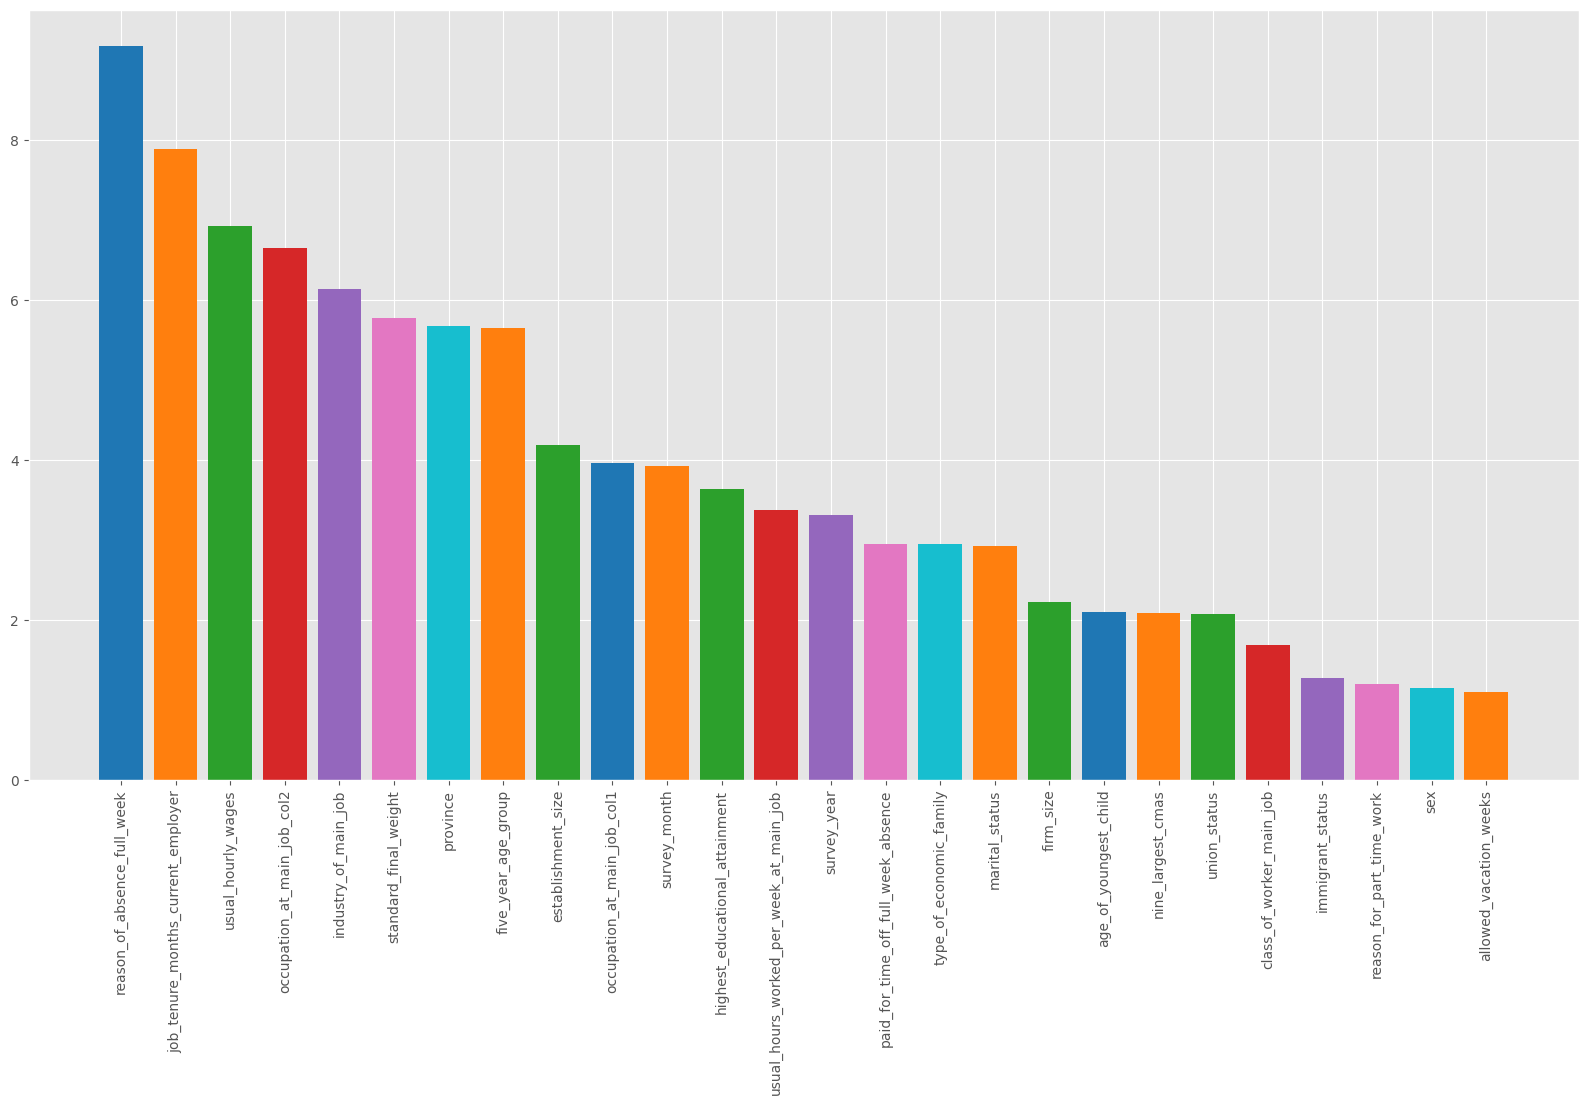

In [68]:
feature_importances = pd.DataFrame(list(zip(model.get_feature_importance(), x_train.columns)))
feature_importances.columns = ['importance', 'feature']
feature_importances = feature_importances.sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize =(20, 10))
color =['tab:blue', 'tab:orange',
'tab:green', 'tab:red', 'tab:purple',
'tab:pink', 'tab:cyan',
'tab:orange', 'tab:green']
ax.bar(feature_importances.feature,
feature_importances['importance'],
color = color)
ax.spines['bottom'].set_position('zero')
#ax.set_ylim([-0.5,0.7])
plt.xticks(rotation=90)
plt.style.use('ggplot');